In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Additional libraries for text preprocessing and feature engineering
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
# READ THE FILE INTO A DATAFRAME
df = pd.read_csv("../../Fake review detection dataset/Yelp Dataset Reduced.csv")

In [4]:
df.head()

,ID,USER_ID,PRODUCT_ID,RATING,DATE,LABEL,REVIEW_TEXT,AVERAGE_RATING,RATING_DEVIATION,TOTAL_PRODUCT_REVIEWS,...,RATING_CATEGORY,SINGLE_RATING_CATEGORY,REVIEW_COUNT_DATE,SAME_DATE_MULTIPLE_REVIEWS,MAX_USER_REVIEWS_DAY,TIMESTAMP_DIFFERENCE,AVERAGE_USER_REVIEW_LENGTH,TOTAL_USER_REVIEWS,PERCENTAGE_POSITIVE_REVIEWS,RATIO_POSITIVE_NEGATIVE
0,144828,66563,416,4,10-12-2014,-1,Great.....,3.767293,0.232707,2183,...,1,1,1,0,2,0 days,11.500000,2,100.0,6.157377
1,157607,74755,449,4,26-03-2013,1,My family and I had Bubby's brunch on a Saturd...,3.396552,0.603448,812,...,1,1,2,0,2,1723 days,724.666667,12,100.0,3.121827
2,70401,49165,237,3,11-10-2011,1,"I really like this place, but they need to get...",3.799003,0.799003,602,...,1,1,2,0,1,0 days,314.000000,1,100.0,6.082353
3,124810,75653,363,5,14-01-2014,1,This is one of my favorite places in the US. A...,3.990361,1.009639,2075,...,1,1,1,0,1,0 days,280.000000,1,100.0,9.121951
4,42068,32402,100,4,02-12-2014,1,Make sure you go with a small group of friends...,3.951812,0.048188,2677,...,1,1,2,0,1,398 days,255.666667,3,100.0,8.734545


In [5]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special characters
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])    
    return text

df["REVIEW_TEXT"] = df["REVIEW_TEXT"].apply(preprocess_text)

In [6]:
df.rename(columns = {'Unnamed: 0':'ID'}, inplace = True)
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].str.replace(' days', '')
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].astype(int)
num_features = df.drop(['ID','USER_ID','PRODUCT_ID','DATE','REVIEW_TEXT','LABEL'],axis=1)
df['LABEL'] = df['LABEL'].replace({-1: 1, 1: 0})

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['REVIEW_TEXT'] , df['LABEL'], test_size=0.25, random_state=42)

print('X_train.shape:', X_train.shape)

print('X_test.shape', X_test.shape)

X_train.shape: (14955,)
X_test.shape (4985,)


In [8]:
print(X_train)

5864     sunday night friends line consistently door mo...
17712    place amazing kitchen sink salad mac n cheese ...
7463     large portions cheap pricing legitly delicious...
4294     extra virgin little pricey worth every penny e...
7975     italian citizen readily admit italian snob gro...
                               ...                        
11284    love love love decor great nice days windows c...
11964    8 pm wednesday long wait place packedgotta goo...
5390     warning spot gets packed really good food drin...
860      always end brunch least twice month nearby dom...
15795    came bf first started dating really gross prob...
Name: REVIEW_TEXT, Length: 14955, dtype: object


In [9]:
# Load pre-trained GloVe embeddings

# Load pre-trained GloVe embeddings
# Replace 'glove.6B.100d.txt' with the path to your GloVe embeddings file
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_glove_embeddings('../../Fake review detection dataset/glove.6B.200d.txt')

# Function to normalize GloVe embeddings
def normalize_embeddings(embeddings):
    for word, embedding in embeddings.items():
        norm = np.linalg.norm(embedding)  # Calculate L2 norm
        if norm != 0:
            embeddings[word] = embedding / norm  # Normalize embedding
    return embeddings

# Normalize GloVe embeddings
normalized_glove_embeddings = normalize_embeddings(glove_embeddings)

In [10]:
#print(normalized_glove_embeddings)

In [11]:
def text_to_embedding(text, embeddings):
    words = text.split()
    embedding = np.zeros(next(iter(embeddings.values())).shape)
    word_count = 0
    for word in words:
        if word in embeddings:
            embedding += embeddings[word]
            word_count += 1
    if word_count > 0:
        embedding /= word_count
        embedding = np.maximum(embedding, 0)  # Clip negative values to zero
    return embedding

# Convert text data into embeddings
X_train_embeddings = np.array([text_to_embedding(text, normalized_glove_embeddings) for text in X_train])
X_test_embeddings = np.array([text_to_embedding(text, normalized_glove_embeddings) for text in X_test])

In [12]:
print(X_train_embeddings.shape)
print(X_test_embeddings.shape)
print(y_train.shape)
print(y_test.shape)

(14955, 100)
(4985, 100)
(14955,)
(4985,)


In [13]:
print(X_test_embeddings)

[[0.         0.05048616 0.05400723 ... 0.         0.05608391 0.05516595]
 [0.         0.0698033  0.02973743 ... 0.         0.0578522  0.05488485]
 [0.         0.06470511 0.0513527  ... 0.         0.06221884 0.06026137]
 ...
 [0.         0.04165807 0.03220272 ... 0.         0.07548137 0.00979572]
 [0.00242469 0.03657366 0.04437542 ... 0.         0.0432883  0.07556708]
 [0.         0.05286627 0.04901296 ... 0.         0.0684871  0.04284045]]


In [14]:
# Apply SMOTE for balancing classes
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_embeddings, y_train)

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
print(X_train_resampled)

[[0.         0.05957507 0.03458603 ... 0.         0.05269226 0.05667407]
 [0.         0.04752837 0.00976674 ... 0.         0.04597544 0.0667971 ]
 [0.         0.05051426 0.02979357 ... 0.         0.07165324 0.03050611]
 ...
 [0.00309054 0.03949985 0.05848099 ... 0.         0.04970718 0.06768343]
 [0.00318133 0.04106159 0.05739066 ... 0.         0.05609083 0.06280748]
 [0.00153837 0.04879219 0.05477645 ... 0.         0.06173968 0.06915014]]


In [17]:
# MultinomialNB  Classifer
model = MultinomialNB() 

# Fit the model
model.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [18]:
# Make predictions
y_pred = model.predict(X_test_embeddings)

In [19]:
print(X_test_embeddings.shape)
print(y_pred.shape)

(4985, 100)
(4985,)


In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8144433299899699
Confusion Matrix:
 [[3923  561]
 [ 364  137]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      4484
           1       0.20      0.27      0.23       501

    accuracy                           0.81      4985
   macro avg       0.56      0.57      0.56      4985
weighted avg       0.84      0.81      0.83      4985



In [21]:
# Predict probabilities for test data
y_pred_proba = model.predict_proba(X_test_embeddings)[:, 1]

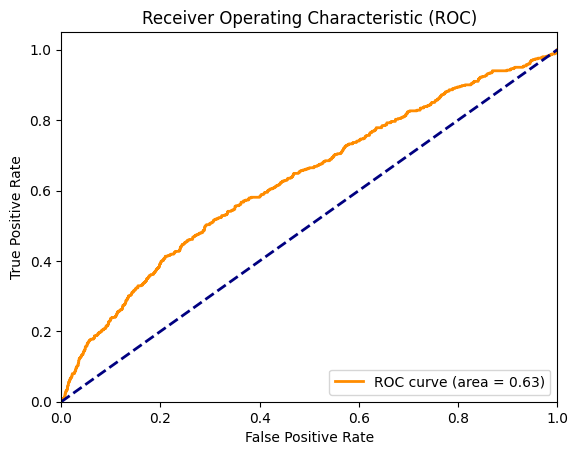

In [22]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print sensitivity and specificity
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

Sensitivity (True Positive Rate): 0.27345309381237526
Specificity (True Negative Rate): 0.8748884924174843
